In [1]:
using Turing
using Plots

[Turing]: AD chunk size is set as 40


In [2]:
@model gdemo(x) = begin
  s ~ InverseGamma(2,3)
  m ~ Normal(0,sqrt(s))
  x[1] ~ Normal(m, sqrt(s))
  x[2] ~ Normal(m, sqrt(s))
  return s, m
end

gdemo (generic function with 2 methods)

In [3]:
mf = gdemo([1.5, 2.0])

[Turing]:  Assume - `s` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `m` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Observe - `x` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57


##gdemo_model#700 (generic function with 4 methods)

In [4]:
chn = sample(mf, NUTS(2000, 0.65))

[Turing] looking for good initial eps...
[Turing.NUTS] found initial ϵ: 1.6


[NUTS] Sampling...  0%  ETA: 10:09:26
  ϵ:         1.6
[NUTS] Sampling... 15%  ETA: 0:01:51
  ϵ:         0.09143757384156184
[NUTS] Sampling... 43%  ETA: 0:00:27
  ϵ:         0.3690510617278854
[NUTS] Sampling... 74%  ETA: 0:00:07
  ϵ:         0.2810928572038822
  pre_cond:  [0.475532, 0.503232]

[NUTS] Finished with
  Running time        = 21.234858526000018;
  #lf / sample        = 0.003;
  #evals / sample     = 8.94;
  pre-cond. diag mat  = [0.475532, 0.503232].


[NUTS] Sampling...100% Time: 0:00:22


Object of type "Turing.Chain"

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

[1.10706 6.0 … -10.5846 1.6; 1.10706 0.0 … -4.89962 4.90753; … ; 0.638548 0.0 … -5.54955 0.281093; 1.93221 0.0 … -5.73806 0.281093]

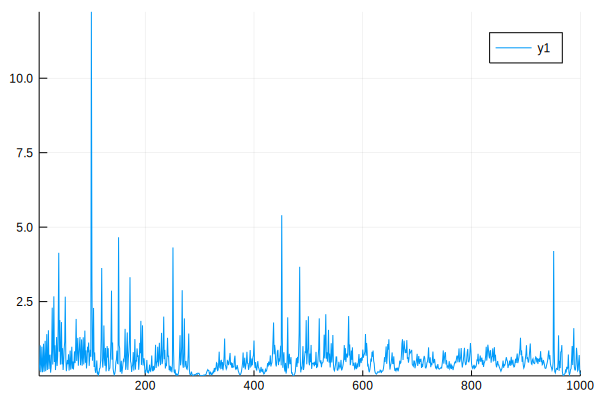

In [5]:
idcs = 5:1000
plot(idcs, chn[:lf_eps][idcs])

In [6]:
using JLD

INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.6/Blosc.ji for module Blosc.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.6/HDF5.ji for module HDF5.
INFO: Recompiling stale cache file /Users/kai/.julia/lib/v0.6/JLD.ji for module JLD.


In [7]:
lda_data = load("./video/lda-data.jld")["data"]

Dict{String,Any} with 9 entries:
  "w"     => [3, 1, 7, 1, 3, 2, 3, 2, 2, 2  …  4, 6, 5, 8, 4, 3, 3, 5, 4, 5]
  "M"     => 50
  "N"     => 755
  "doc"   => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  50, 50, 50, 50, 50, 50, 50, 50, …
  "V"     => 10
  "α"     => [0.25, 0.25, 0.25, 0.25]
  "K"     => 4
  "words" => String["river", "stream", "bank", "money", "loan", "bayes", "gauss…
  "β"     => [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [9]:
# Pre-compute indics
lda_data["lidx"] =
  (lda_data["doc"] .- 1) .* lda_data["V"] .+ lda_data["w"]

# Collapsed version with vectorization for (huge) speed-up
@model lda_model_vec(K, V, M, N, w, doc, β, α, lidx) = begin
  θ = Matrix{Real}(K, M)
  θ ~ [Dirichlet(α)]

  ϕ = Matrix{Real}(V, K)
  ϕ ~ [Dirichlet(β)]

  log_ϕ_dot_θ = log.(ϕ * θ)
  # lp = mapreduce(n -> log_ϕ_dot_θ[w[n], doc[n]], +, 1:N)
  lp = sum(broadcast_getindex(log_ϕ_dot_θ, lidx))
  Turing.acclogp!(vi, lp)
end

lda_model_vec (generic function with 10 methods)

In [10]:
lda_vec_chn = sample(lda_model_vec(data=lda_data),
                     NUTS(200, 1000, 0.65))

[Turing]:  Assume - `θ` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `ϕ` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing] looking for good initial eps...
[Turing.NUTS] found initial ϵ: 0.2


[NUTS] Sampling...  0%  ETA: 1:12:59
  ϵ:         0.2
[NUTS] Sampling...  1%  ETA: 0:38:02
  ϵ:         0.6134417423832448
[NUTS] Sampling...  2%  ETA: 0:27:43
  ϵ:         0.09338907794456619
[NUTS] Sampling...  2%  ETA: 0:22:58
  ϵ:         0.011075690570811984
[NUTS] Sampling...  2%  ETA: 0:19:19
  ϵ:         0.0037994400303850216
[NUTS] Sampling...  3%  ETA: 0:17:09
  ϵ:         0.003866255597875061
[NUTS] Sampling...  4%  ETA: 0:15:16
  ϵ:         0.006872712539151841
[NUTS] Sampling...  4%  ETA: 0:13:53
  ϵ:         0.009081925910603996
[NUTS] Sampling...  4%  ETA: 0:12:53
  ϵ:         0.01120960522652377
[NUTS] Sampling...  5%  ETA: 0:12:22
  ϵ:         0.010158281193726242
[NUTS] Sampling...  6%  ETA: 0:11:31
  ϵ:         0.004166421368678511
[NUTS] Sampling...  6%  ETA: 0:10:50
  ϵ:         0.004265544668991373
[NUTS] Sampling...  6%  ETA: 0:10:17
  ϵ:         0.008180197956797426
[NUTS] Sampling...  7%  ETA: 0:09:52
  ϵ:         0.025112551835967147
[NUTS] Sampling...  8%  ET

[NUTS] Sampling... 64%  ETA: 0:01:41
  ϵ:         0.005269200755466609
[NUTS] Sampling... 64%  ETA: 0:01:39
  ϵ:         0.003434916095042695
[NUTS] Sampling... 66%  ETA: 0:01:36
  ϵ:         0.008652014970377143
[NUTS] Sampling... 66%  ETA: 0:01:33
  ϵ:         0.02537698019267938
[NUTS] Sampling... 68%  ETA: 0:01:29
  ϵ:         0.005712896907110905
[NUTS] Sampling... 68%  ETA: 0:01:26
  ϵ:         0.005220471929872475
[NUTS] Sampling... 70%  ETA: 0:01:23
  ϵ:         0.004207463021523875
[NUTS] Sampling... 70%  ETA: 0:01:23
  ϵ:         0.001853495887180922
[NUTS] Sampling... 71%  ETA: 0:01:20
  ϵ:         0.011168412480358717
[NUTS] Sampling... 72%  ETA: 0:01:17
  ϵ:         0.0067262293717552475
[NUTS] Sampling... 73%  ETA: 0:01:13
  ϵ:         0.013975925547249562
[NUTS] Sampling... 74%  ETA: 0:01:10
  ϵ:         0.007670977427830082
[NUTS] Sampling... 75%  ETA: 0:01:07
  ϵ:         0.006630238308631955
[NUTS] Sampling... 76%  ETA: 0:01:04
  ϵ:         0.031357116254901916
[NUTS]

[NUTS] Finished with
  Running time        = 259.35266541;
  #lf / sample        = 0.015;
  #evals / sample     = 64.505;
  pre-cond. diag mat  = [0.59877, 0.801597, 0.549112, ....


[NUTS] Sampling...100% Time: 0:04:20


Object of type "Turing.Chain"

Iterations = 1:200
Thinning interval = 1
Chains = 1
Samples per chain = 200

[0.638333 0.241964 … 0.177045 0.0269002; 0.708348 0.164753 … 0.162056 0.0179004; … ; 0.802641 0.118565 … 0.0375621 0.039997; 0.803553 0.118654 … 0.0378327 0.0410661]

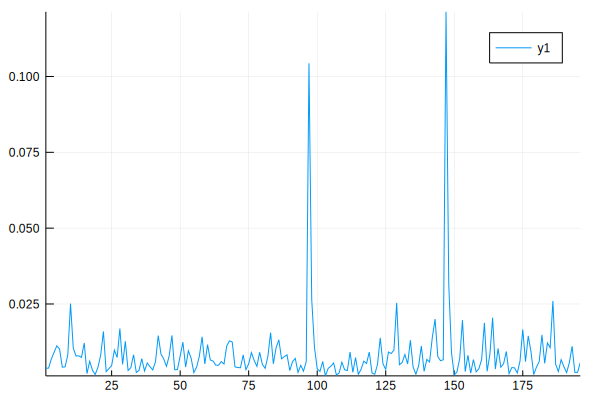

In [11]:
plot(lda_vec_chn[:lf_eps][5:end])